# **Filtros convolucionales**

Implementación de funciones que retornen el kernel a partir de los parámetros especificados de cada filtro.

In [1]:
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

In [2]:
# +--------------------------------------------------------------------+
# |                            CÁLCULO DE LA FFT                       |
# +--------------------------------------------------------------------+
def img_fftShift(image):
    image = image/255.0 if image.max() > 1 else image
    image_gray = image if image.ndim==2 else rgb2yiq(image[..., 0:3])[...,0]
    image_fft = np.fft.fftshift(np.fft.fft2(image_gray))
    N, M = image_gray.shape
    image_fft = image_fft / (N * M) # FFT values in range [0, 1]
    Im = np.abs(image_fft)          # Magnitude of the spectrum in range [0, 1]
    alpha, beta = 1, 10e4
    Im_log = np.log10(alpha + Im * beta)
    return Im_log

# +--------------------------------------------------------------------+
# |                             CÁLCULO DEL RMSE                       |
# +--------------------------------------------------------------------+
def rmse(img1, img2):
    return np.sqrt(np.mean((img1-img2)**2))

# +--------------------------------------------------------------------+
# |                                  GRAFICOS                          |
# +--------------------------------------------------------------------+
def plot3(image1, image2, image3=None, titles=[]):
    '''Grafica una grilla de una fila con 2 o 3 columnas.'''
    cols = 3 if image3 is not None else 2
    
    fig, axes = plt.subplots(1, cols, figsize=(15,10))
    axes[0].imshow(image1, 'gray')
    axes[1].imshow(image2, 'gray')
    
    if cols > 2:
        axes[2].imshow(image3, 'gray')
    
    if titles:
        axes[0].set_title(titles[0])
        axes[1].set_title(titles[1])
        
        if cols > 2:
            axes[2].set_title(titles[2])
    
    plt.show()

# Imagen de prueba

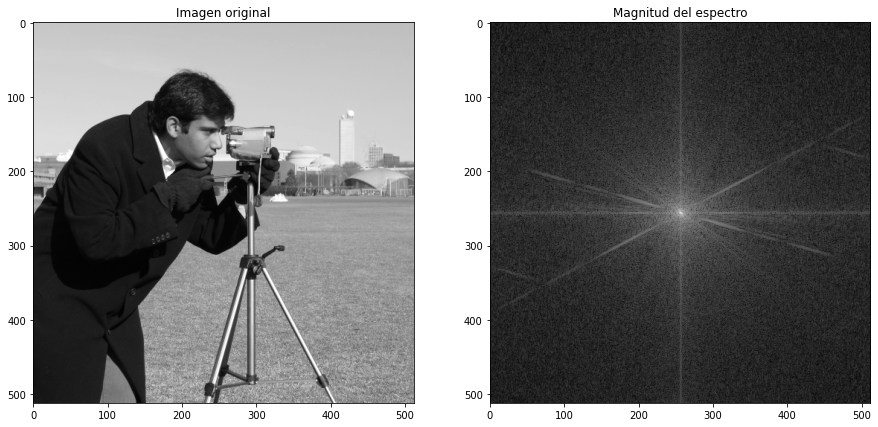

In [3]:
img = imageio.imread('imageio:camera.png')/255
img_fft = img_fftShift(img)

plot3(img, img_fft, titles = ['Imagen original', 'Magnitud del espectro'])

# **1. Filtros simétricos**

Filtros invariantes a la rotación de 90°. El tamaño del kernel de los filtros son de $M*M$; donde $M$ debe ser impar.

* **1.1. Pasa-bajos:** 

    1. Box (cuadrado)
    2. Circle (circular)
    3. Bartlett
    4. Gaussian


* **1.2. Pasa-altos:**

    1. Laplace (4 y 8 vecinos)
    2. Pasaaltos a partir de un pasabajos


* **1.3. Pasa-banda:**

    1. Difference of Gaussian (DoG)


* **1.4. Otros:**

    1. Mejora de contraste

In [4]:
def is_size_correct(M):
    '''Verifica que el tamaño del kernel (M) sea correcto'''
    correct = True
    error = ''
    out = np.array([], dtype=np.result_type(M, 0.0))
    if M < 1:
        correct = False
        error = '''
        >> El tamaño del filtro debe ser superior a la unidad.
           Tamaño ingresado (M): {}.
        '''
    elif M == 1:
        correct = False
        error = '''
        >> El tamaño del filtro es igual a la unidad (M = {}).
        '''
        out = np.ones(1, dtype=np.result_type(M, 0.0))
    elif (M % 2) == 0:
        correct = False
        error = '''
        >> El tamaño del filtro debe ser IMPAR.
           Tamaño ingresado (M): {}.
        '''
    return correct, error.format(M), out

## **1.1. Filtros Pasa-Bajos**

### **1.1.1. Box (cuadrado)**

$$kernel = \frac{1}{M * M}\begin{bmatrix}
 1& \cdots & 1 \\
 \vdots & \ddots  & \vdots  \\
 1& \cdots & 1 \\
\end{bmatrix}$$

In [5]:
def box_kernel(M):
    '''
    Acción: Retorna un kernel 2D con coeficientes de igual 
            valor (1) y un tamaño de (M, M)
    
    Parámetros
    ----------
    M : Int 
        Tamaño del filtro Box.
    
    Salida
    ------
    out: numpy.ndarray
         Matriz de unos de tamaño (M, M) con sus coeficientes 
         divididos por la sumatoria de los mismos.
    '''
    correct, error, out = is_size_correct(M)
    if not correct:
        print(error)
        return out
    
    return np.ones((M, M), np.float32) / (M * M)

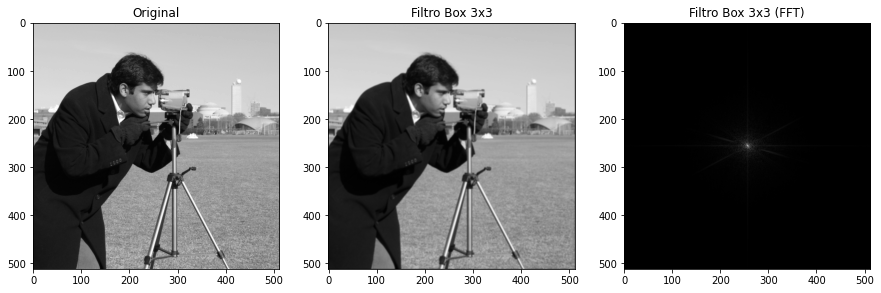

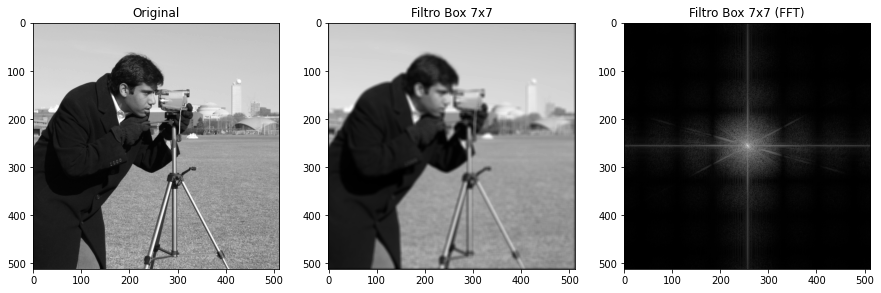

In [6]:
img_box3 = convolve2d(img, box_kernel(3), 'same')
img_box7 = convolve2d(img, box_kernel(7), 'same')

plot3(img, img_box3, img_fftShift(img_box3), titles=['Original', 'Filtro Box 3x3', 'Filtro Box 3x3 (FFT)'])
plot3(img, img_box7, img_fftShift(img_box7), titles=['Original', 'Filtro Box 7x7', 'Filtro Box 7x7 (FFT)'])

### **1.1.2. Circle (circular)**

**Referencias:** 
* [Disk-shaped footprint Skimage](https://scikit-image.org/docs/dev/api/skimage.morphology.html#disk)
* [Coding a circular filter Stack Overflow](https://stackoverflow.com/questions/45426091/coding-a-circular-filter-in-python)

Kernel en forma de círculo a partir de la distancia euclidiana. Para ello, se establece el radio ($r$) a partir del tamaño ***M*** elegido y luego se crea una ventana de 1-dimension ($L$) en el rango [-r, r] con incremento unitario.

$$r = \frac{M-1}{2}$$

$$L = [(-r), (-r+1),(-r+2),...,r]$$

A partir de la ventana anterior, se aplica la función `mershgrid` para generar una matriz de 2-D de la forma (M, M) vertical ($X$) y horizontal ($Y$).

$$X, Y = \text{meshgrid}(L, L)$$

Finalmente se calcula la distancia entre los puntos generados arriba ($d_{(X, Y)}$) y se genera el kernel a partir de la evaluación de la misma con el radio ($r$)

$$d_{(X, Y)} = \sqrt{X^2 + Y^2}$$


$$
{kernel_{(x,y)}}^* = \begin{cases}
  1, & d_{(X, Y)} \leq r\\
  0, & d_{(X, Y)} > r\\
\end{cases}
$$

\* El kernel generado se normaliza, dividiendo cada uno de sus coeficientes entre la suma todos.

In [7]:
def circle_kernel(M):
    '''
    Acción: Retorna un kernel 2D promediado con forma circular 
             de tamaño (M, M)
    
    Parámetros
    ----------
    M : Int 
        Tamaño del filtro Circle.
    
    Salida
    ------
    out: numpy.ndarray
         Matriz de unos en forma circular con tamaño (M, M) y sus 
         coeficientes divididos por la sumatoria de los mismos.
    '''
    correct, error, out = is_size_correct(M)
    if not correct:
        print(error)
        return out
    
    kernel = np.zeros((M, M))
    radius = (M - 1) / 2
    L = np.arange(-radius, radius + 1)
    X, Y = np.meshgrid(L, L)
    mask = np.array((X ** 2 + Y ** 2) <= radius ** 2)
    kernel[mask] = 1
    
    return kernel / np.sum(kernel)

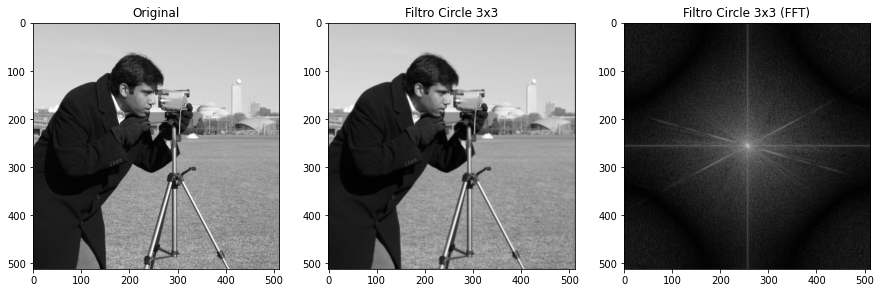

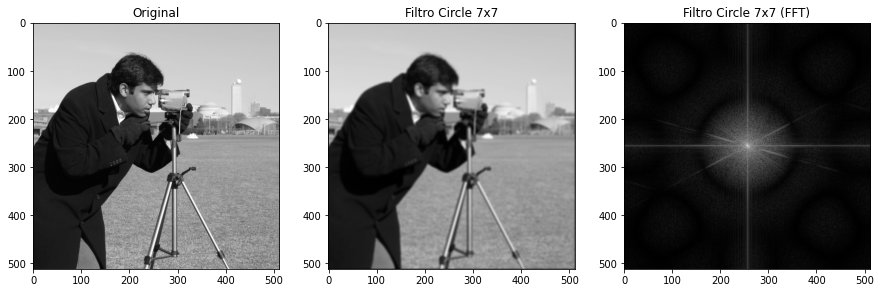

In [8]:
img_circle3 = convolve2d(img, circle_kernel(3), 'same')
img_circle7 = convolve2d(img, circle_kernel(7), 'same')

plot3(img, img_circle3, img_fftShift(img_circle3), titles=['Original', 'Filtro Circle 3x3', 'Filtro Circle 3x3 (FFT)'])
plot3(img, img_circle7, img_fftShift(img_circle7), titles=['Original', 'Filtro Circle 7x7', 'Filtro Circle 7x7 (FFT)'])

### **1.1.3. Bartlett**
**Referencia:** [Numpy Bartlett window](https://numpy.org/doc/stable/reference/generated/numpy.bartlett.html)

Matemáticamente se define como:

$$w(n)=\frac{2}{M-1}\left(\frac{M-1}{2}-\left|n-\frac{M-1}{2}\right|\right)$$

Lo cual, puede ser simplificado a lo siguiente:

$$w(n)=1-\frac{2}{M-1}\left|n-\frac{M-1}{2}\right|$$

Es decir:

$$w(n) = \left\{\begin{matrix}
 \frac{2n}{M-1},& n\leq \frac{M-1}{2} \\
 2-\frac{2n}{M-1},& n > \frac{M-1}{2} \\
\end{matrix}\right.$$

Donde $w(n)$ es la "ventana de datos" que contiene los coeficientes del filtro en 1D a partir de la lista $n$ y $M$ es el tamaño del filtro.

In [9]:
def bartlett_kernel(M):
    '''
    Acción: Retorna un kernel 2D correspondiente al filtro
            Bartlett de tamaño (M, M) y ganancia unitaria.
    
    Parámetros
    ----------
    M : Int 
        Tamaño del filtro Bartlett.
    
    Salida
    ------
    out: numpy.ndarray
         Producto exterior del filtro Bartlett de 1D con sus
         coeficientes divididos por la sumatoria de los mismos.
    '''
    correct, error, out = is_size_correct(M)
    if not correct:
        print(error)
        return out
    
    n = np.arange(0, M)
    w = np.where(np.less_equal(n, (M - 1) / 2.0),
                 2.0 * n / (M - 1), 
                 2.0 - 2.0 * n / (M - 1))
    
    # Coeficientes en 1D enteros
    w_1D =  w * ((M-1) / 2) + 1 
    kernel = np.outer(w_1D, w_1D)
    
    return kernel / np.sum(kernel)

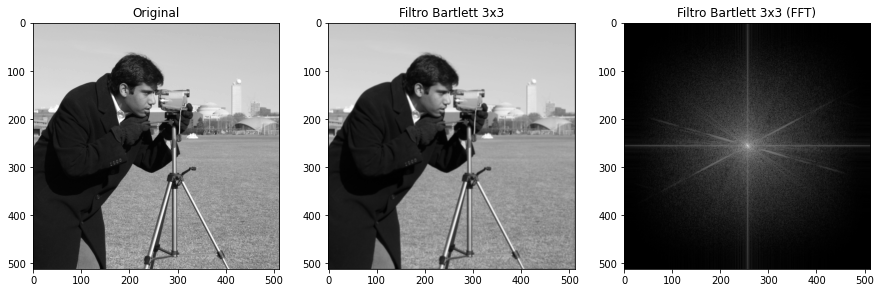

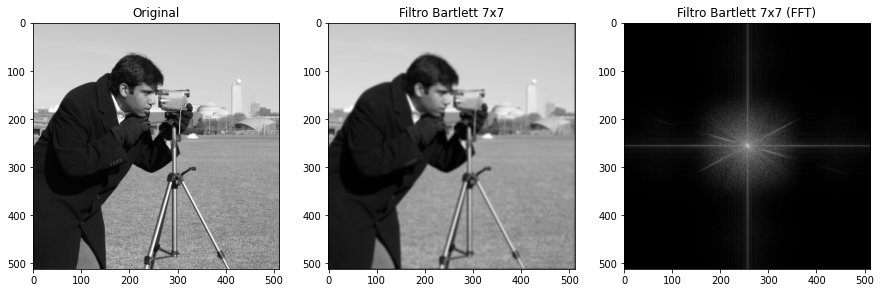

In [10]:
img_bartlett3 = convolve2d(img, bartlett_kernel(3), 'same')
img_bartlett7 = convolve2d(img, bartlett_kernel(7), 'same')

plot3(img, img_bartlett3, img_fftShift(img_bartlett3), 
      titles=['Original', 'Filtro Bartlett 3x3', 'Filtro Bartlett 3x3 (FFT)'])

plot3(img, img_bartlett7, img_fftShift(img_bartlett7), 
      titles=['Original', 'Filtro Bartlett 7x7', 'Filtro Bartlett 7x7 (FFT)'])

### **1.1.4. Gaussian**

**Referencias:**
* [Gaussian window Scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.gaussian.html#scipy.signal.windows.gaussian)
* [Stack Overflow examples](https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy)

La ventana Gaussiana se define de la siguiente manera:

### $$w(n) = e^{-\frac{1}{2}\left(\frac{n}{\sigma}\right)^2}$$

Donde $w(n)$ es la ventana con una cantidad de puntos $n$; $\sigma$ es la desviación estándar

In [11]:
def gaussian_kernel(std, M=None):
    '''
    Acción: Retorna un kernel referente al filtro
            gaussiano en 2D.
    
    Parámetros
    ----------
    M : Int 
        Tamaño del filtro Gaussiano.
    
    std: Float
         Desviación estándar (sigma) para el kernel Gaussiano.
    
    Salida
    ------
    out: numpy.ndarray
         Kernel Gaussiano con sus coeficientes normalizados con 
         el máximo valor equivalente a 1.
         
         Si se especifica 'M', el tamaño del kernel será (M, M).
         De lo contrario este se infiere a partir de 'std' de la
         siguiente manera:
             
             radius = int(4.0*sigma + 0.5)
             tamaño kernel = (radius * 2) + 1
    '''
    # Especifica tamaño del kernel
    if M is not None:
        correct, error, out = is_size_correct(M)
        if not correct:
            print(error)
            return out
        
        n = np.arange(0, M) - (M - 1.0) / 2.0
    
    # Solo se ingresa 'std'
    else:
        truncate = 4.0
        radius = int(truncate * std + 0.5)
        n = np.arange(-radius, radius+1)
    
    sig2 = 2 * std * std
    w = np.exp(-n ** 2 / sig2)
    kernel = np.outer(w, w)
    return kernel / np.sum(kernel)

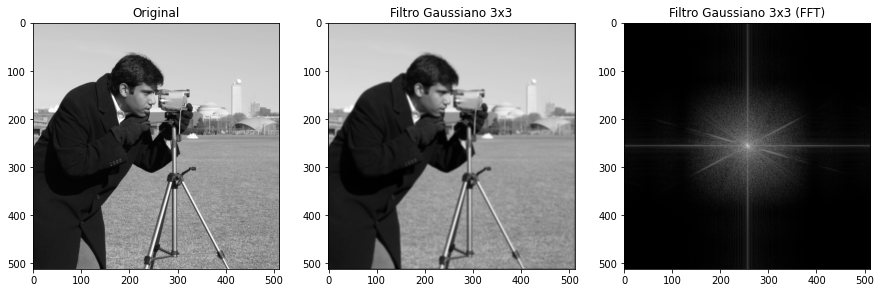

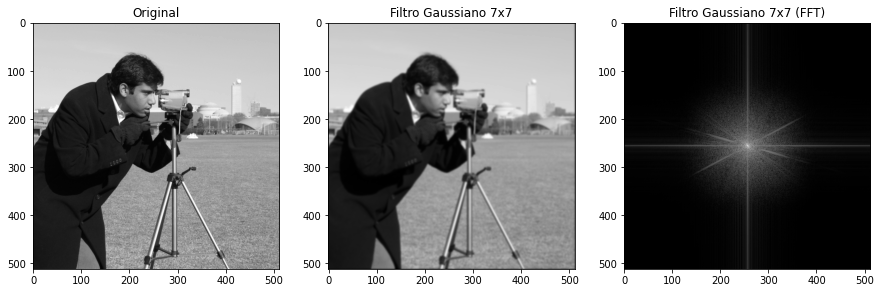

In [12]:
img_gaussian3 = convolve2d(img, gaussian_kernel(std=1.5, M=5), 'same')
img_gaussian7 = convolve2d(img, gaussian_kernel(std=1.5, M=7), 'same')

plot3(img, img_gaussian3, img_fftShift(img_gaussian3), 
      titles=['Original', 'Filtro Gaussiano 3x3', 'Filtro Gaussiano 3x3 (FFT)'])

plot3(img, img_gaussian7, img_fftShift(img_gaussian7), 
      titles=['Original', 'Filtro Gaussiano 7x7', 'Filtro Gaussiano 7x7 (FFT)'])

## **1.2. Filtros Pasa-Altos**

### **1.2.1. Laplace**

- **4 vecinos**

$$kernel_{(V4)} =\begin{bmatrix}
 0&  -1& 0 \\
 -1&  4 & -1 \\
 0 & -1 & 0 \\
\end{bmatrix}
$$

- **8 vecinos**

$$kernel_{(V8)} =\begin{bmatrix}
 -1&  -1& -1 \\
 -1&  8 & -1 \\
 -1 & -1 & -1 \\
\end{bmatrix}
$$

In [13]:
def laplacian_kernel(neighbors):
    '''
    Parámetros
    ----------
    neighbors: Int 
               Cantidad de vecinos del filtro laplaciano.
    
    Salida
    ------
    out: numpy.ndarray
         Retorna un kernel 2D laplaciano de tamaño (3, 3)
         de 4 u 8 vecinos según corresponda.
    '''
    if neighbors == 8:
        return np.array([[-1, -1, -1],
                         [-1,  8, -1],
                         [-1, -1, -1]])
    
    elif neighbors == 4:
        return np.array([[0, -1, 0],
                         [-1, 4, -1],
                         [0, -1, 0]])
    else:
        print(">> El parámetro 'neighbors' debe se 4 u 8")
        print("   'neighbors' ingresado:", neighbors)
        return np.array([])

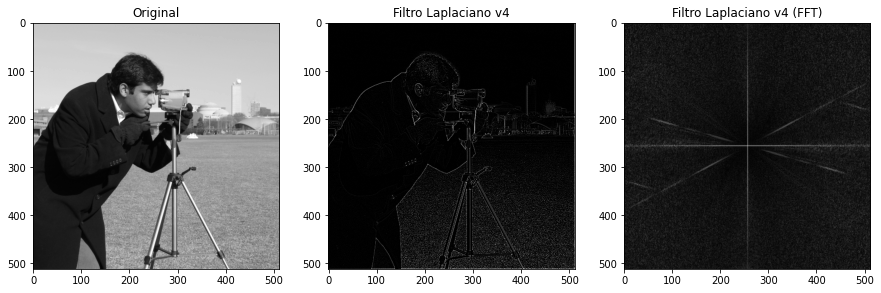

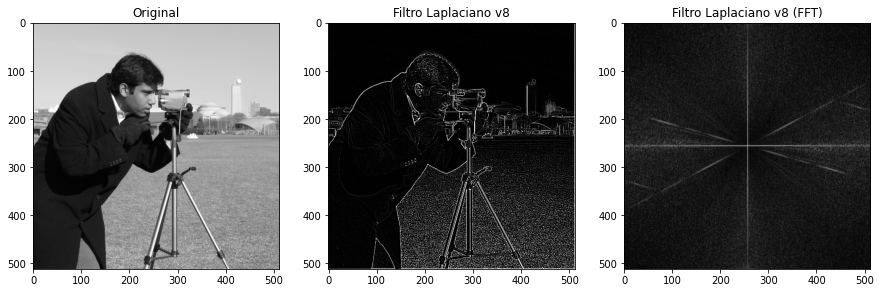

In [14]:
img_laplacian4 = convolve2d(img, laplacian_kernel(4), 'same')
img_laplacian8 = convolve2d(img, laplacian_kernel(8), 'same')

plot3(img, np.clip(img_laplacian4, 0, 1), img_fftShift(img_laplacian4), 
      titles=['Original', 'Filtro Laplaciano v4', 'Filtro Laplaciano v4 (FFT)'])

plot3(img, np.clip(img_laplacian8, 0, 1), img_fftShift(img_laplacian8), 
      titles=['Original', 'Filtro Laplaciano v8', 'Filtro Laplaciano v8 (FFT)'])

### **1.2.2. High-Pass**

Desarrollo de un filtro pasa altos a partir de uno pasa bajos. Expresado matemáticamente:

$$kernel_{HighPass} = kernel_{ID} - kernel_{LowPass}$$

Donde $kernel_{ID}$ es el kernel del filtro identidad y $kernel_{LowPass}$ es el kernel del filtro pasa-bajos elegido.

In [15]:
def highPass_kernel(M, lowPass_filter=1, std=None):
    '''    
    Parámetros
    ----------
    M : Int 
        Tamaño del filtro Gaussiano.
    
    lowPass_filter:  Int
                     Tipo de filtro pasa-bajos a usar:
                 
                     ==============  =======================
                     lowPass_filter  Filter
                     ==============  =======================
                            1        Box (por defecto)
                            2        Circle
                            3        Bartlett
                            4        Gaussian
                     ==============  =======================

                     Si se selecciona el filtro Gaussiano, se
                     debe especificar el parámetro 'std'.
    
    std: Float
         Desviación estándar (sigma) para el kernel del
         filtro Gaussiano (en caso de implementarse).
    
    
    Salida
    ------
    out: numpy.ndarray
         Kernel de un filtro pasa-altos de 2D con tamaño (M, M) 
         creado a partir del filtro pasa-bajos elegido.
    '''
    correct, error, out = is_size_correct(M)
    if not correct:
        print(error)
        return out
    
    # Filtro pasa-bajos
    if lowPass_filter > 4 or lowPass_filter < 1:
        print(">> 'lowPass_filter' debe ser de tipo Int entre [1, 4]")
        return out
    elif lowPass_filter == 1:
        LP_filter = box_kernel(M)
    elif lowPass_filter == 2:
        LP_filter = circle_kernel(M)
    elif lowPass_filter == 3:
        LP_filter = bartlett_kernel(M)
    else:
        LP_filter = gaussian_kernel(M=M) if std is None else gaussian_kernel(std=std, M=M)
        
    # Filtro identidad
    middle_pos = int((M-1)/2)
    ID_filter = np.zeros((M, M))
    ID_filter[middle_pos, middle_pos] = 1
    
    return ID_filter - LP_filter

Se prueba el filtro pasa altos usando un filtro gaussiano con `std=2` y tamaños de `3x3` y `7x7`

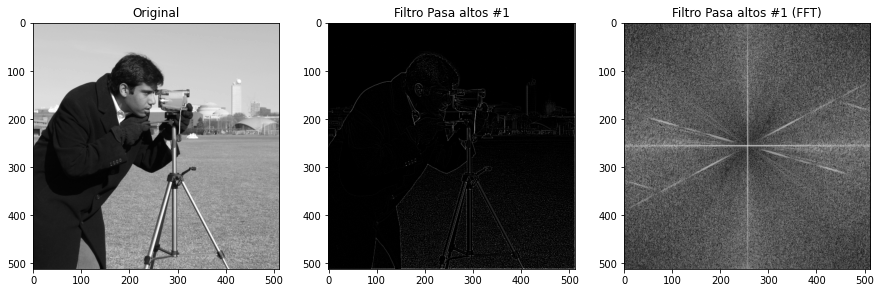

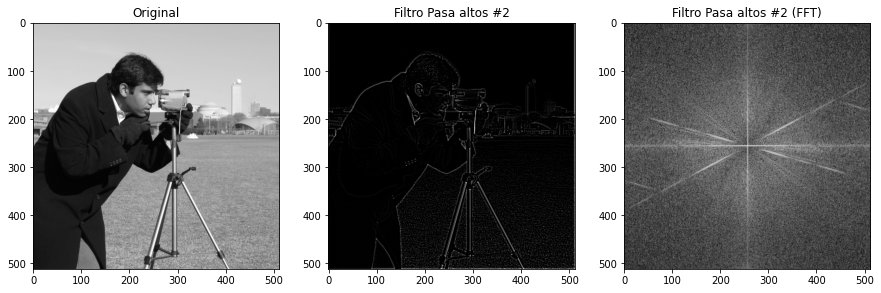

In [16]:
img_highPass1 = convolve2d(img, highPass_kernel(M=3, lowPass_filter=4, std=2), 'same')
img_highPass2 = convolve2d(img, highPass_kernel(M=7, lowPass_filter=4, std=2), 'same')

plot3(img, np.clip(img_highPass1, 0, 1), img_fftShift(img_highPass1), 
      titles=['Original', 'Filtro Pasa altos #1', 'Filtro Pasa altos #1 (FFT)'])

plot3(img, np.clip(img_highPass2, 0, 1), img_fftShift(img_highPass2), 
      titles=['Original', 'Filtro Pasa altos #2', 'Filtro Pasa altos #2 (FFT)'])

## **1.3. Filtro Pasa-Banda**

### **1.3.1. Difference of Gaussians (DoG)**

**Referencias:**
* [Gaussian Filter | Scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html)
* [DoG | Skimage](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.difference_of_gaussians)

El kernel de este tipo de filtro se crea a partir de la construcción de dos kernels gaussianos (de tamaño $M$) con una desviación estandar inferior ($\sigma_{low}$) y superior ($\sigma_{high}$).

$$kernel_{(gaussian1)} = \text{gaussian_kernel}(M, \sigma_{low})$$
$$kernel_{(gaussian2)} = \text{gaussian_kernel}(M, \sigma_{high})$$

$$kernel_{(DoG)} = kernel_{(gaussian1)} - kernel_{(gaussian2)}$$

In [17]:
def difference_of_gaussians_kernel(low_sigma, high_sigma, M=None):
    '''
    Parámetros
    ----------
    low_sigma: Float
               Desviación estándar para el kernel Gaussiano con
               el valor de sigma más pequeño.
    
    high_sigma: Float
                Desviación estándar para el kernel Gaussiano con
                el valor de sigma más grande.
    
    M : Int 
        Tamaño del filtro Gaussiano.
    
    Salida
    ------
    out: numpy.ndarray
         Kernel 2D con la diferencia entre un filtro gaussiano con 
         'low_sigma' y 'high_sigma'. Sus coeficientes son normalizados 
         con el máximo valor equivalente a 1.
    '''
    if M is not None:
        correct, error, out = is_size_correct(M)
        if not correct:
            print(error)
            return out
    
    if low_sigma > high_sigma:
        print(">> 'high_sigma' debe ser igual o mayor que 'low_sigma'")
        return out
    
    kernel_low = gaussian_kernel(low_sigma, M)
    kernel_high = gaussian_kernel(high_sigma, M)
    
    return kernel_low - kernel_high

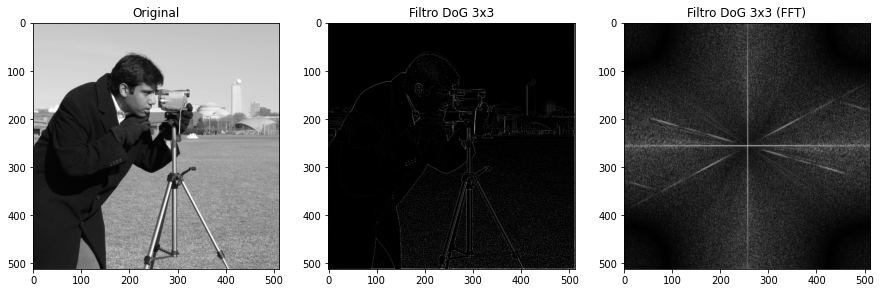

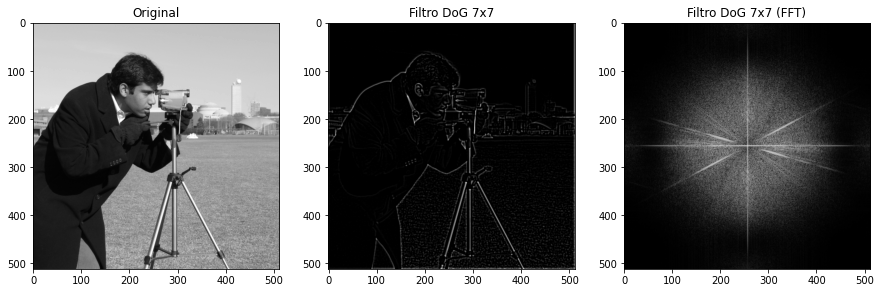

In [18]:
img_dog3 = convolve2d(img, difference_of_gaussians_kernel(1, 2, M=3), 'same')
img_dog7 = convolve2d(img, difference_of_gaussians_kernel(1, 2, M=7), 'same')

plot3(img, np.clip(img_dog3, 0, 1), img_fftShift(img_dog3), 
      titles=['Original', 'Filtro DoG 3x3', 'Filtro DoG 3x3 (FFT)'])

plot3(img, np.clip(img_dog7, 0, 1), img_fftShift(img_dog7), 
      titles=['Original', 'Filtro DoG 7x7', 'Filtro DoG 7x7 (FFT)'])

## **1.4. Filtro de mejora**

### $$kernel = kernel_{ID} + (w * kernel_{HighPass})$$

Donde $w$ es el factor que define la influencia del filtro pasa altos en la imagen resultante.

In [19]:
def edge_enhance_kernel(weight, hihg_pass_kernel):
    
    if weight > 1.0 or weight < 0.0:
        print(">> 'weight' debe ser de tipo Float en el rango [0.0, 1.0]")
        return out
    
    # Filtro identidad
    M = hihg_pass_kernel.shape[0]
    middle_pos = int((M-1)/2)
    ID_filter = np.zeros((M, M))
    ID_filter[middle_pos, middle_pos] = 1
    
    return ID_filter + (weight * hihg_pass_kernel)

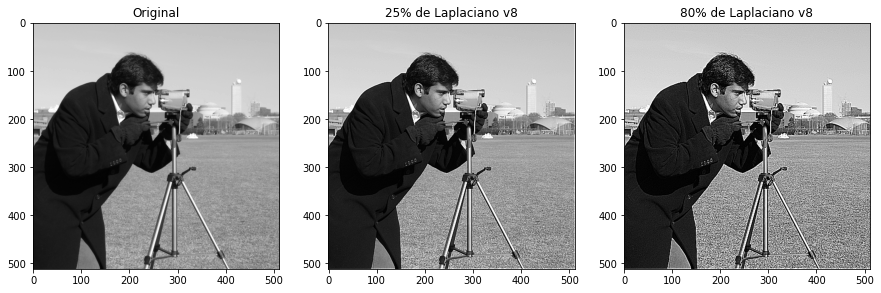

In [20]:
img_mejora1 = convolve2d(img, edge_enhance_kernel(0.25, laplacian_kernel(8)), 'same')
img_mejora2 = convolve2d(img, edge_enhance_kernel(0.8, laplacian_kernel(8)), 'same')

plot3(img, np.clip(img_mejora1, 0, 1), np.clip(img_mejora2, 0, 1), 
      titles=['Original', '25% de Laplaciano v8', '80% de Laplaciano v8'])

# **2. Filtros Asimétricos**

## **2.1. Direccionales**

### **2.1.1. Sobel (3x3)**

In [21]:
def sobel_kernel(direction):
    '''
    Parámetros
    ----------
    direction: String
               Dirección del kernel Sobel. Opciones:
               
                ============  ====================
                 direction    Filter direction
                ============  ====================
                    'N'       Norte    (North)
                    'S'       Sur      (South)
                    'E'       Este     (East)
                 'O' or 'W'   Oeste    (West)
                    'NE'      Noreste  (Northeast)
                    'SE'      Sureste  (Southeast)
                'NO' or 'NW'  Noroeste (Northwest)
                'SO' or 'SW'  Suroeste (Southwest)
                ============  ====================
    
    Salida
    ------
    out: Numpy.ndarray
         Kernel 3x3 con los coeficientes del filtro Sobel 
         respectivos a la dirección ingresada por parámetro.
    '''
    if direction == 'E':
        return np.array([[1, 0, -1],
                         [2, 0, -2],
                         [1, 0, -1]])

    elif direction == 'NE':
        return np.array([[0, -1,  -2],
                         [1,  0, -1],
                         [2,  1,  0]])

    elif direction == 'N':
        return np.array([[-1, -2, -1],
                         [ 0,  0, 0],
                         [ 1,  2, 1]])

    elif (direction == 'NO') or (direction == 'NW'):
        return np.array([[-2, -1,  0],
                         [-1,  0,  1],
                         [ 0,  1,  2]])

    elif (direction == 'W') or (direction == 'O'):
        return np.array([[-1,  0,  1],
                         [-2,  0,  2],
                         [-1,  0,  1]])

    elif (direction == 'SO') or (direction == 'SW'):
        return np.array([[ 0,  1, 2],
                         [-1,  0, 1],
                         [-2, -1, 0]])

    elif direction == 'S':
        return np.array([[ 1,  2,   1],
                         [ 0,  0,  0],
                         [-1, -2, -1]])

    elif direction == 'SE':
        return np.array([[ 2,  1,  0],
                         [ 1,  0, -1],
                         [ 0, -1, -2]])

    else:
        print(">> Parametro 'direction' inválido")
        return np.array([])

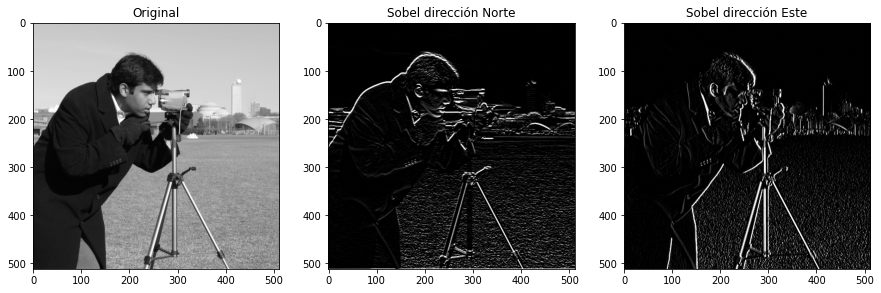

In [22]:
img_sobelN = convolve2d(img, sobel_kernel('N'), 'same')
img_sobelE = convolve2d(img, sobel_kernel('E'), 'same')

plot3(img, np.clip(img_sobelN, 0, 1), np.clip(img_sobelE, 0, 1), 
      titles=['Original', 'Sobel dirección Norte', 'Sobel dirección Este'])

# **3. Detector de bordes**

1. Se obtiene el valor de los gradientes horizontales ($G_x$) y verticales ($G_y$). Estos se obtienen aplicando el filtro Sobel en dirección *Norte* o *Sur* ($G_y$) y *Este* u *Oeste* ($G_x$) a la imagen.


2. Ahora, se calcula el módulo de estos gradientes: $G = \sqrt{{G_x}^2 + {G_y}^2}$


3. Por último, se binariza la imagen tal que los píxeles en la posición `x, y` ($I_{(x, y)}$) por debajo o igual de un umbral ($a$) adquieren el valor de `0` y caso contrario de `1`.

$$I_{(x, y)} = \begin{cases}1, & I_{(x, y)} > a\\0, & I_{(x, y)} \leq a\end{cases}$$

In [23]:
def edge_detector(image, umbral=0.7):
    '''Detector de bordes a partir de filtros Sobel 3x3'''
    Gx = convolve2d(image, sobel_kernel('N'), 'same')
    Gy = convolve2d(image, sobel_kernel('E'), 'same')

    phase = np.arctan2(Gy, Gx)
    phase =(phase + np.pi)/(2*np.pi)

    module = np.sqrt(Gx**2 + Gy**2)

    return (module > umbral).astype('uint8')

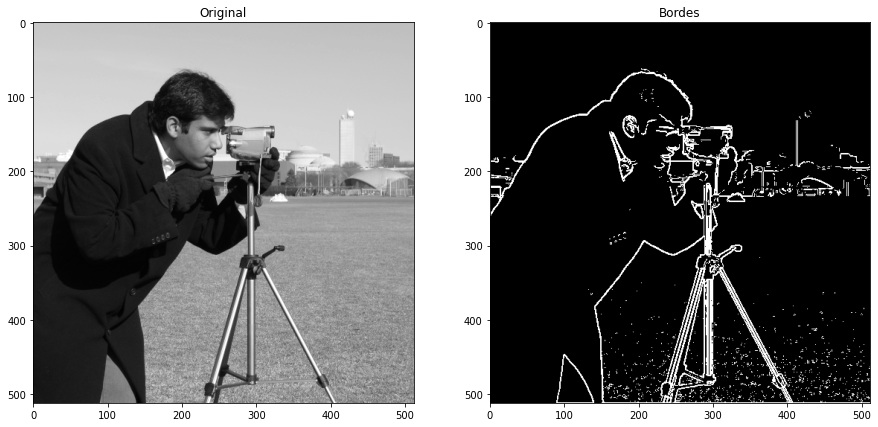

In [24]:
plot3(img, edge_detector(img), titles=['Original', 'Bordes'])

# 4. Filtro Canny (Descripción)

1. **Noise reduction:** suavización de la imagen, típicamente, aplicando un filtro Gaussiano sobre la imagen. Esto, ya que la detección de bordes es sensible ante el ruido presente en la imagen.


2. **Gradient calculation:** cálculo de la intensidad y fase de los bordes mediante una aplicación idéntica a la vista en la detección de bordes usando el filtro Sobel.


3. **Non-maximum suppression:** se 'adelgazan' los bordes ya que el resultado del paso anterior arroja bordes con diferente grosor. Se recorren los píxeles del módulo del gradiente y se toman los valores más grandes para los píxeles que se encuentren en la misma dirección.


4. **Double threshold:** identificación de tres tipos de píxeles: **fuertes**, **débiles** y **no relevantes**. Para esto, se establecen dos umbrales (alto y bajo) y a partir de la evaluación de los píxeles con estos se '*clasifican*'. 

    - Si el valor del pixel está por encima del umbral alto, es considerado como un píxel **`fuerte`**. 
    - Si el valor se encuentra entre el umbral alto y bajo, el pixel se etiqueta como **`débil`**. 
    - Finalmente, si la intensidad está por debajo del umbral bajo, se denomina como **`no relevante`**. Estos píxeles son suprimidos de la imagen.


5. **Edge Tracking by Hysteresis:** transformación de píxeles débiles en fuertes. Esto se realiza si y solo si el píxel procesado en una posición `x, y` tiene por lo menos alguno de tipo fuerte a su alrededor.

## Links de interés

- [**Examples of Sobel filters**](https://stackoverflow.com/questions/58383477/how-to-create-a-python-convolution-kernel)

- [**Sobel kernels (8 directions)**](https://www.researchgate.net/figure/Sobel-operators-in-eight-directions_fig1_277887850)

- [**Signal windows, Scipy**](https://github.com/scipy/scipy/blob/v1.8.1/scipy/signal/windows/_windows.py#L1216-L1276)

- [**Some OpenCV filters**](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html)

- [**Canny algorithm | Skimage**](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.canny)

- [**Canny Edge Detection | Blog**](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123)

- [**Canny Edge Detection | Wikipedia**](https://en.wikipedia.org/wiki/Canny_edge_detector#Process)